In [1]:
# Import packages
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt
import copy
from IPython.display import display
import json
from pathlib import Path
import sys
import seaborn as sns

2.b: Now we add an battery investment cost and a scaling factor, to finde the best investment over the 10 year lifetime of the battery

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[rosetta2] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 265 rows, 193 columns and 578 nonzeros
Model fingerprint: 0x594eb126
Coefficient statistics:
  Matrix range     [9e-01, 6e+00]
  Objective range  [2e+03, 1e+04]
  Bounds range     [3e+00, 5e+00]
  RHS range        [1e-01, 1e+03]
Presolve removed 97 rows and 10 columns
Presolve time: 0.00s
Presolved: 168 rows, 183 columns, 473 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0259500e+07   8.107995e+03   0.000000e+00      0s
     107    1.0339271e+05   0.000000e+00   0.000000e+00      0s

Solved in 107 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.033927114e+05

Optimal s_bat: 1.567 (× baseline) → 9.40 kWh
Total cost (10 years): 103392.71 DKK
Investment cost: 9400.00 DKK


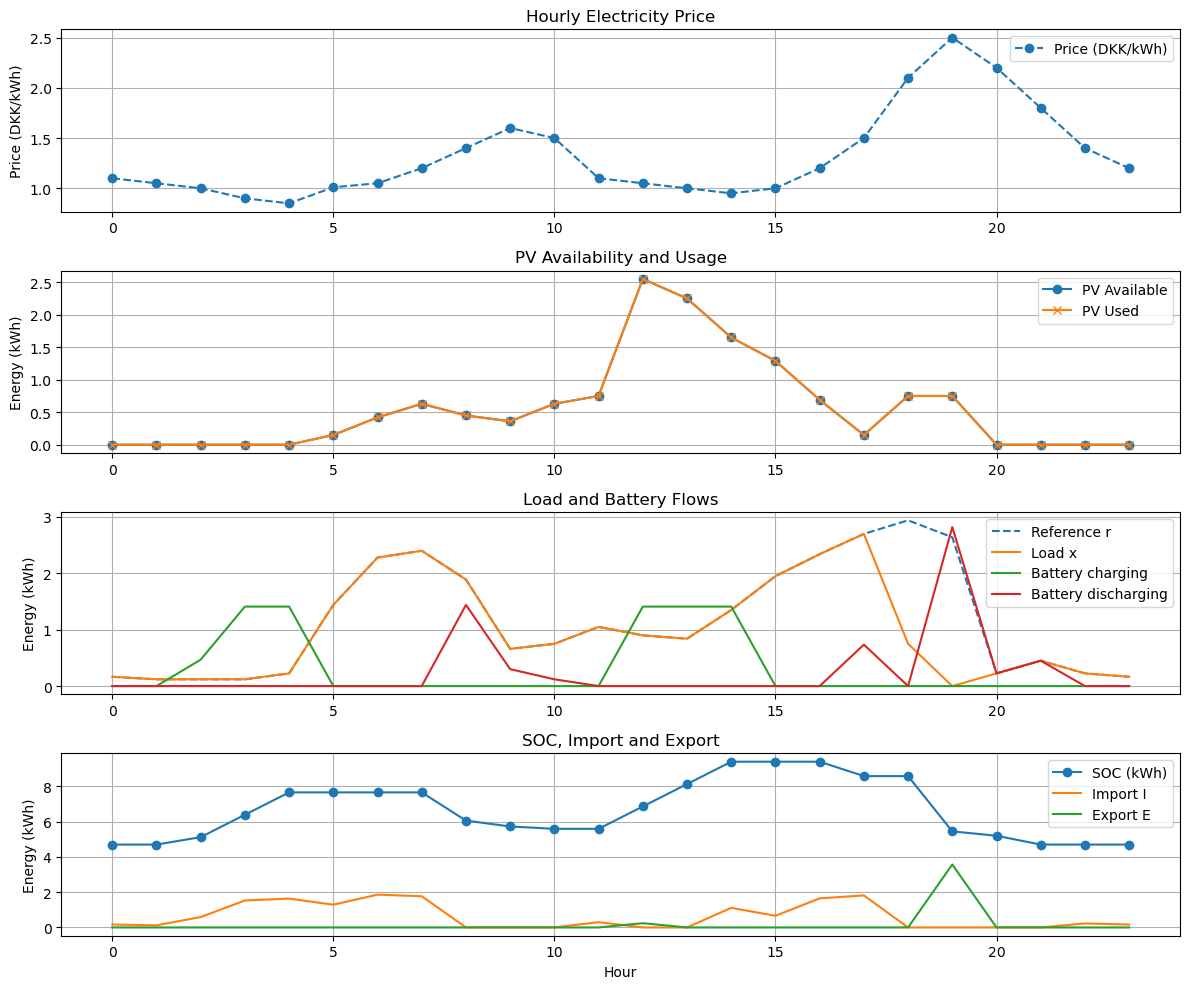

In [9]:

USER_SETTINGS = {
    "investment_cost_DKK_per_kWh": 1000,   # CAPEX cost per kWh of capacity (source: https://www.solarchoice.net.au/solar-batteries/is-home-battery-storage-worth-it/)
    "s_bat_upper_bound": 5.0,                # Max scaling factor for battery (× baseline)
    "analysis_years": 10,                    # Battery lifetime in years
    "representative_days": 365,              # How many days 1 simulated day represents
}

# -------- Utils --------
def load_json(path: Path):
    if path.exists():
        return json.loads(path.read_text())
    return None

# -------- Paths --------
base_folder = Path("data/question_1c/")
appliance_path = base_folder / "appliance_params.json"
bus_path = base_folder / "bus_params.json"
consumer_path = base_folder / "consumer_params.json"
der_prod_path = base_folder / "DER_production.json"
usage_pref_path = base_folder / "usage_preferences.json"

appliance_params = load_json(appliance_path)
bus_params = load_json(bus_path)
consumer_params = load_json(consumer_path)
DER_production = load_json(der_prod_path)
usage_pref = load_json(usage_pref_path)

# Single consumer / bus assumption
consumer = consumer_params[0]
bus = bus_params[0]

# -------- Specs --------
pv_spec = appliance_params["DER"][0]
pv_max_kW = float(pv_spec["max_power_kW"])

load_spec = appliance_params["load"][0]
load_max_kWh = float(load_spec["max_load_kWh_per_hour"])

storage_spec = appliance_params["storage"][0]
storage_id = storage_spec["storage_id"]

# Baseline battery parameters
C0 = float(storage_spec["storage_capacity_kWh"])  # capacity [kWh]
max_charging_power_ratio = float(storage_spec["max_charging_power_ratio"])
max_discharging_power_ratio = float(storage_spec["max_discharging_power_ratio"])
eta_ch = float(storage_spec["charging_efficiency"])
eta_dis = float(storage_spec["discharging_efficiency"])
P_ch0 = max_charging_power_ratio * C0
P_dis0 = max_discharging_power_ratio * C0

# --- User override values (from USER_SETTINGS block) ---
c_inv = float(USER_SETTINGS["investment_cost_DKK_per_kWh"])
s_bat_ub = float(USER_SETTINGS["s_bat_upper_bound"])
L_years = int(USER_SETTINGS["analysis_years"])
N_rep = int(USER_SETTINGS["representative_days"])

# Storage prefs (SoC ratios)
storage_prefs = usage_pref[0].get("storage_preferences", [])
initial_soc_ratio = float(storage_prefs[0]["initial_soc_ratio"])
final_soc_ratio = float(storage_prefs[0]["final_soc_ratio"])

# Bus parameters
prices = bus["energy_price_DKK_per_kWh"]
if len(prices) != 24:
    raise SystemExit(f"Expected 24 hourly prices; got {len(prices)}")

import_tariff = float(bus["import_tariff_DKK/kWh"])
export_tariff = float(bus["export_tariff_DKK/kWh"])
max_import = float(bus["max_import_kW"])
max_export = float(bus["max_export_kW"])

der_profile = DER_production[0]["hourly_profile_ratio"]
if len(der_profile) != 24:
    raise SystemExit("Expected 24 hourly DER profile entries")
pv_avail = [pv_max_kW * float(r) for r in der_profile]

# Load reference profile
load_prefs = usage_pref[0].get("load_preferences", [])
if not load_prefs:
    raise SystemExit("No load_preferences found in usage_preferences.json")
lp0 = load_prefs[0]
hourly_profile_ratio = lp0.get("hourly_profile_ratio", None)
if hourly_profile_ratio is None or len(hourly_profile_ratio) != 24:
    raise SystemExit("Expected a 24-entry hourly_profile_ratio for the load")
r = [float(ratio) * load_max_kWh for ratio in hourly_profile_ratio]

# Discomfort penalty
gamma = 2.0
T = list(range(24))

# -------- Model --------
m = gp.Model("consumer_flex_lp_with_battery_investment")
m.setParam('OutputFlag', 1)

# Investment variable (battery scaling)
s_bat = m.addVar(lb=0.0, ub=s_bat_ub, name="s_bat")

# Operational variables
x = m.addVars(T, lb=0.0, ub=load_max_kWh, name="x")
u = m.addVars(T, lb=0.0, name="u")
I = m.addVars(T, lb=0.0, name="I")
E = m.addVars(T, lb=0.0, name="E")
d = m.addVars(T, lb=0.0, name="d")

# Battery variables
p_ch = m.addVars(T, lb=0.0, name="p_ch")
p_dis = m.addVars(T, lb=0.0, name="p_dis")
SOC = m.addVars(T, lb=0.0, name="SOC")

# PV availability
for t in T:
    m.addConstr(u[t] <= pv_avail[t], name=f"pv_cap_{t}")

# Import/export caps
for t in T:
    m.addConstr(I[t] <= max_import, name=f"import_cap_{t}")
    m.addConstr(E[t] <= max_export, name=f"export_cap_{t}")

# Energy balance
for t in T:
    m.addConstr(I[t] - E[t] + u[t] + p_dis[t] == x[t] + p_ch[t], name=f"balance_{t}")

# Deviation constraints
for t in T:
    m.addConstr(d[t] >= x[t] - r[t], name=f"dev_pos_{t}")
    m.addConstr(d[t] >= r[t] - x[t], name=f"dev_neg_{t}")

# Battery power limits
for t in T:
    m.addConstr(p_ch[t] <= s_bat * P_ch0,  name=f"p_ch_cap_{t}")
    m.addConstr(p_dis[t] <= s_bat * P_dis0, name=f"p_dis_cap_{t}")

# SoC dynamics
m.addConstr(
    SOC[0] == (initial_soc_ratio * s_bat * C0)
    + eta_ch * p_ch[0] - (1.0 / eta_dis) * p_dis[0],
    name="soc_0"
)
for t in T[1:]:
    m.addConstr(
        SOC[t] == SOC[t - 1] + eta_ch * p_ch[t] - (1.0 / eta_dis) * p_dis[t],
        name=f"soc_{t}"
    )

# SoC limits
for t in T:
    m.addConstr(SOC[t] >= 0.0, name=f"soc_min_{t}")
    m.addConstr(SOC[t] <= s_bat * C0, name=f"soc_max_{t}")

# Terminal SoC condition
m.addConstr(SOC[T[-1]] >= (final_soc_ratio * s_bat * C0), name="terminal_soc")

# Objective function (lifetime cost)
daily_oper_cost = gp.quicksum(
    (prices[t] + import_tariff) * I[t]
    - (prices[t] - export_tariff) * E[t]
    + gamma * d[t]
    for t in T
)
lifetime_oper_cost = L_years * N_rep * daily_oper_cost
investment_cost = c_inv * C0 * s_bat
m.setObjective(lifetime_oper_cost + investment_cost, GRB.MINIMIZE)

# -------- Solve --------
m.optimize()

if m.Status == GRB.OPTIMAL:
    # Results
    x_sol = [x[t].X for t in T]
    u_sol = [u[t].X for t in T]
    I_sol = [I[t].X for t in T]
    E_sol = [E[t].X for t in T]
    d_sol = [d[t].X for t in T]
    p_ch_sol = [p_ch[t].X for t in T]
    p_dis_sol = [p_dis[t].X for t in T]
    SOC_sol = [SOC[t].X for t in T]

    print(f"\nOptimal s_bat: {s_bat.X:.3f} (× baseline) → {s_bat.X * C0:.2f} kWh")

    objective_value = m.ObjVal
    print(f"Total cost (10 years): {objective_value:.2f} DKK")
    print(f"Investment cost: {c_inv * C0 * s_bat.X:.2f} DKK")

    # ---- Plot ----
    plt.figure(figsize=(12, 10))
    plt.subplot(4, 1, 1)
    plt.plot(T, prices, label="Price (DKK/kWh)", linestyle='--', marker='o')
    plt.ylabel("Price (DKK/kWh)")
    plt.title("Hourly Electricity Price")
    plt.grid()
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(T, pv_avail, label="PV Available", marker='o')
    plt.plot(T, u_sol, label="PV Used", marker='x')
    plt.ylabel("Energy (kWh)")
    plt.title("PV Availability and Usage")
    plt.grid()
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(T, r, label="Reference r", linestyle='--')
    plt.plot(T, x_sol, label="Load x")
    plt.plot(T, p_ch_sol, label="Battery charging")
    plt.plot(T, p_dis_sol, label="Battery discharging")
    plt.ylabel("Energy (kWh)")
    plt.title("Load and Battery Flows")
    plt.grid()
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(T, SOC_sol, label="SOC (kWh)", marker='o')
    plt.plot(T, I_sol, label="Import I")
    plt.plot(T, E_sol, label="Export E")
    plt.xlabel("Hour")
    plt.ylabel("Energy (kWh)")
    plt.title("SOC, Import and Export")
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Model not solved to optimality. Status:", m.Status)



Running scenario: Base (import=0.5, export=0.4)
 c_inv  s_bat_opt  capacity_opt_kWh  investment_cost_DKK  total_cost_10y_DKK
   200   5.000000              30.0               6000.0        88596.194722
   500   5.000000              30.0              15000.0        97596.194722
  1000   1.566667               9.4               9400.0       103392.711389
  1500   0.800000               4.8               7200.0       107978.669722
  2000   0.333333               2.0               4000.0       109073.016389
  2500   0.000000               0.0                  0.0       109325.347500

Running scenario: High tariff (import=1.0, export=0.8)
 c_inv  s_bat_opt  capacity_opt_kWh  investment_cost_DKK  total_cost_10y_DKK
   200   1.833333              11.0               2200.0         112360.8325
   500   1.833333              11.0               5500.0         115660.8325
  1000   1.566667               9.4               9400.0         120760.9525
  1500   1.566667               9.4             

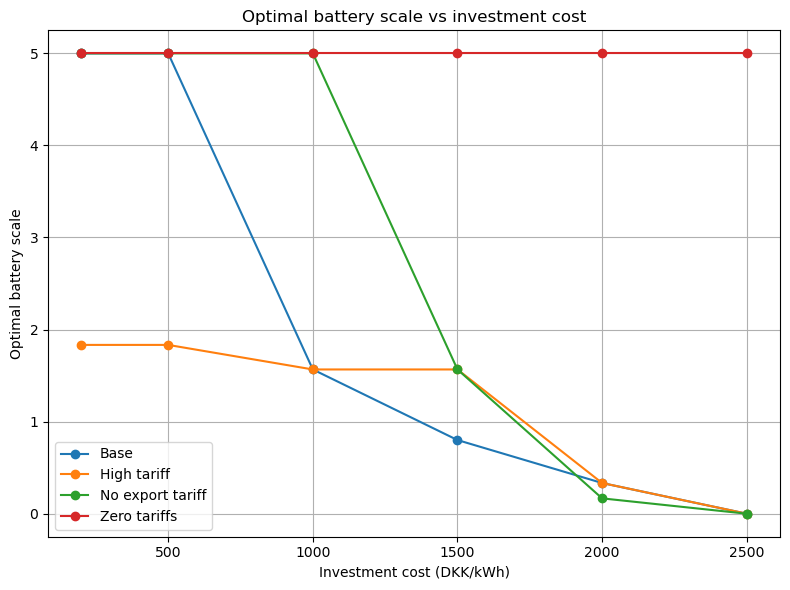

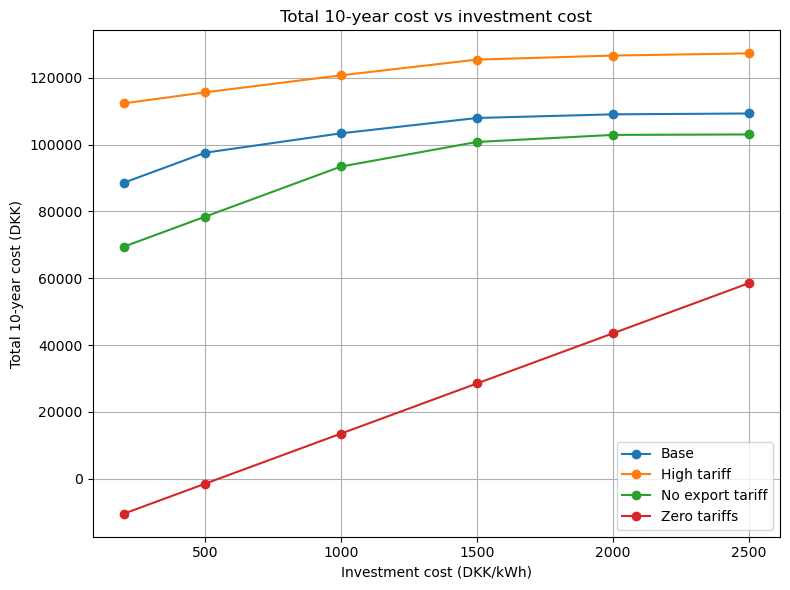


Summary - best CAPEX choice per scenario (from sweep):
  Base: best CAPEX entry = 200 DKK/kWh -> capacity = 30.00 kWh
  High tariff: best CAPEX entry = 200 DKK/kWh -> capacity = 11.00 kWh
  No export tariff: best CAPEX entry = 200 DKK/kWh -> capacity = 30.00 kWh
  Zero tariffs: best CAPEX entry = 200 DKK/kWh -> capacity = 30.00 kWh


In [ ]:
# ---------- Cost structure simulations ----------

# ---------- Scenario definitions ----------
scenarios = {
    "Base": {"import_tariff": 0.50, "export_tariff": 0.40},
    "High tariff": {"import_tariff": 1.00, "export_tariff": 0.80},
    "No export tariff": {"import_tariff": 0.50, "export_tariff": 0.00},
    "Zero tariffs": {"import_tariff": 0.00, "export_tariff": 0.00},
}

# ---------- CAPEX sweep ----------
capex_list = [200, 500, 1000, 1500, 2000, 2500]  # DKK/kWh - adjust as you like

# ---------- Storage for results ----------
records = []

# Make sure import_tariff/export_tariff names in bus are not used during sweep (we'll override per scenario)
for scenario_name, sc in scenarios.items():
    print(f"\nRunning scenario: {scenario_name} (import={sc['import_tariff']}, export={sc['export_tariff']})")
    for c_inv_val in capex_list:
        # Build model fresh for each run to avoid stale constraints/vars
        m = gp.Model(f"consumer_flex_invest_{scenario_name}_capex_{c_inv_val}")
        m.setParam('OutputFlag', 0)
        # Decision variables
        s_bat = m.addVar(lb=0.0, ub=s_bat_ub, name="s_bat")
        x = m.addVars(T, lb=0.0, ub=load_max_kWh, name="x")
        u = m.addVars(T, lb=0.0, name="u")
        I = m.addVars(T, lb=0.0, name="I")
        E = m.addVars(T, lb=0.0, name="E")
        d = m.addVars(T, lb=0.0, name="d")
        p_ch = m.addVars(T, lb=0.0, name="p_ch")
        p_dis = m.addVars(T, lb=0.0, name="p_dis")
        SOC = m.addVars(T, lb=0.0, name="SOC")

        # Constraints: PV caps, import/export caps, balance, deviation, battery power, SoC dynamics, SoC limits, terminal SoC
        for t in T:
            m.addConstr(u[t] <= pv_avail[t], name=f"pv_cap_{t}")
            m.addConstr(I[t] <= max_import, name=f"import_cap_{t}")
            m.addConstr(E[t] <= max_export, name=f"export_cap_{t}")
            m.addConstr(I[t] - E[t] + u[t] + p_dis[t] == x[t] + p_ch[t], name=f"balance_{t}")
            m.addConstr(d[t] >= x[t] - r[t], name=f"dev_pos_{t}")
            m.addConstr(d[t] >= r[t] - x[t], name=f"dev_neg_{t}")
            m.addConstr(p_ch[t] <= s_bat * P_ch0,  name=f"p_ch_cap_{t}")
            m.addConstr(p_dis[t] <= s_bat * P_dis0, name=f"p_dis_cap_{t}")

        # SoC dynamics
        m.addConstr(
            SOC[0] == (initial_soc_ratio * s_bat * C0)
            + eta_ch * p_ch[0] - (1.0 / eta_dis) * p_dis[0],
            name="soc_0"
        )
        for t in T[1:]:
            m.addConstr(
                SOC[t] == SOC[t - 1] + eta_ch * p_ch[t] - (1.0 / eta_dis) * p_dis[t],
                name=f"soc_{t}"
            )
        for t in T:
            m.addConstr(SOC[t] >= 0.0, name=f"soc_min_{t}")
            m.addConstr(SOC[t] <= s_bat * C0, name=f"soc_max_{t}")

        m.addConstr(SOC[T[-1]] >= (final_soc_ratio * s_bat * C0), name="terminal_soc")

        # Objective: lifetime operational cost + investment cost
        daily_oper_cost = gp.quicksum(
            (prices[t] + sc["import_tariff"]) * I[t]
            - (prices[t] - sc["export_tariff"]) * E[t]
            + gamma * d[t]
            for t in T
        )
        lifetime_oper_cost = L_years * N_rep * daily_oper_cost
        investment_cost = c_inv_val * C0 * s_bat
        m.setObjective(lifetime_oper_cost + investment_cost, GRB.MINIMIZE)

        # Solve
        m.optimize()

        # If infeasible or not optimal store status
        status = m.Status
        if status != GRB.OPTIMAL:
            print(f"  CAPEX {c_inv_val}: model status {status} (not optimal)")
            rec = {
                "scenario": scenario_name,
                "import_tariff": sc["import_tariff"],
                "export_tariff": sc["export_tariff"],
                "c_inv": c_inv_val,
                "status": status
            }
            records.append(rec)
            continue

        # Extract solutions & aggregated metrics
        s_bat_opt = s_bat.X
        invest_cost = c_inv_val * C0 * s_bat_opt
        total_cost_10y = m.ObjVal
        # compute daily operational components (sum over t)
        I_sum = sum(I[t].X for t in T)
        E_sum = sum(E[t].X for t in T)
        u_sum = sum(u[t].X for t in T)
        x_sum = sum(x[t].X for t in T)
        ch_sum = sum(p_ch[t].X for t in T)
        dis_sum = sum(p_dis[t].X for t in T)
        soc_ts = [SOC[t].X for t in T]

        # For convenience compute annual operational cost (divide by L_years * N_rep)
        daily_oper = 0.0
        for t in T:
            daily_oper += (prices[t] + sc["import_tariff"]) * I[t].X - (prices[t] - sc["export_tariff"]) * E[t].X + gamma * d[t].X
        annual_oper_cost = (daily_oper * N_rep)  # note: your lifetime_oper_cost = L_years * N_rep * daily_oper

        # Save record
        rec = {
            "scenario": scenario_name,
            "import_tariff": sc["import_tariff"],
            "export_tariff": sc["export_tariff"],
            "c_inv": c_inv_val,
            "status": status,
            "s_bat_opt": s_bat_opt,
            "capacity_opt_kWh": s_bat_opt * C0,
            "investment_cost_DKK": invest_cost,
            "total_cost_10y_DKK": total_cost_10y,
            "annual_operational_cost_DKK": annual_oper_cost,
            "daily_load_kWh": x_sum,
            "daily_pv_used_kWh": u_sum,
            "daily_import_kWh": I_sum,
            "daily_export_kWh": E_sum,
            "daily_batt_charge_kWh": ch_sum,
            "daily_batt_discharge_kWh": dis_sum,
            "SOC_time_series": soc_ts
        }
        records.append(rec)

    # summary print for this scenario
    df_temp = pd.DataFrame([r for r in records if r['scenario'] == scenario_name and r.get('status') == GRB.OPTIMAL])
    if not df_temp.empty:
        print(df_temp[["c_inv", "s_bat_opt", "capacity_opt_kWh", "investment_cost_DKK", "total_cost_10y_DKK"]].to_string(index=False))
    else:
        print("  No optimal runs for this scenario.")


df_results = pd.DataFrame(records)

# ---------- Plot: s_bat_opt vs CAPEX for each scenario ----------
plt.figure(figsize=(8,6))
for scenario_name in scenarios.keys():
    df_s = df_results[(df_results['scenario']==scenario_name) & (df_results['status']==GRB.OPTIMAL)]
    if df_s.empty:
        continue
    plt.plot(df_s['c_inv'], df_s['s_bat_opt'], marker='o', label=scenario_name)
plt.xlabel("Investment cost (DKK/kWh)")
plt.ylabel("Optimal battery scale")
plt.title("Optimal battery scale vs investment cost")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ---------- Plot: 10-year total cost vs CAPEX ----------
plt.figure(figsize=(8,6))
for scenario_name in scenarios.keys():
    df_s = df_results[(df_results['scenario']==scenario_name) & (df_results['status']==GRB.OPTIMAL)]
    if df_s.empty:
        continue
    plt.plot(df_s['c_inv'], df_s['total_cost_10y_DKK'], marker='o', label=scenario_name)
plt.xlabel("Investment cost (DKK/kWh)")
plt.ylabel("Total 10-year cost (DKK)")
plt.title("Total 10-year cost vs investment cost")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ---------- Quick textual summary ----------
summary_rows = []
for scenario_name in scenarios.keys():
    df_s = df_results[(df_results['scenario']==scenario_name) & (df_results['status']==GRB.OPTIMAL)]
    if df_s.empty:
        summary_rows.append((scenario_name, None, None))
        continue
    # pick CAPEX with min total_cost_10y
    best_row = df_s.loc[df_s['total_cost_10y_DKK'].idxmin()]
    summary_rows.append((scenario_name, best_row['c_inv'], best_row['capacity_opt_kWh']))

print("\nSummary - best CAPEX choice per scenario (from sweep):")
for sname, best_capex, best_kwh in summary_rows:
    if best_capex is None:
        print(f"  {sname}: no optimal solution in sweep")
    else:
        print(f"  {sname}: best CAPEX entry = {best_capex} DKK/kWh -> capacity = {best_kwh:.2f} kWh")


    gamma  investment_cost_per_kWh  s_bat_opt  battery_capacity_kWh  \
0     0.0                      200   5.000000             30.000000   
1     0.5                      200   5.000000             30.000000   
2     1.0                      200   5.000000             30.000000   
3     1.5                      200   5.000000             30.000000   
4     2.0                      200   5.000000             30.000000   
5     2.5                      200   5.000000             30.000000   
6     3.0                      200   5.000000             30.000000   
7     0.0                      500   4.919178             29.515068   
8     0.5                      500   4.919178             29.515068   
9     1.0                      500   4.919178             29.515068   
10    1.5                      500   1.833333             11.000000   
11    2.0                      500   5.000000             30.000000   
12    2.5                      500   5.000000             30.000000   
13    

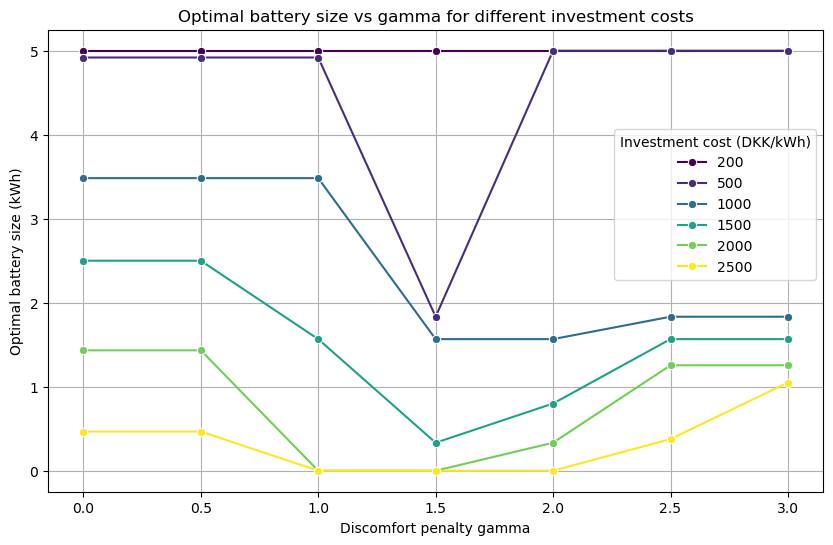

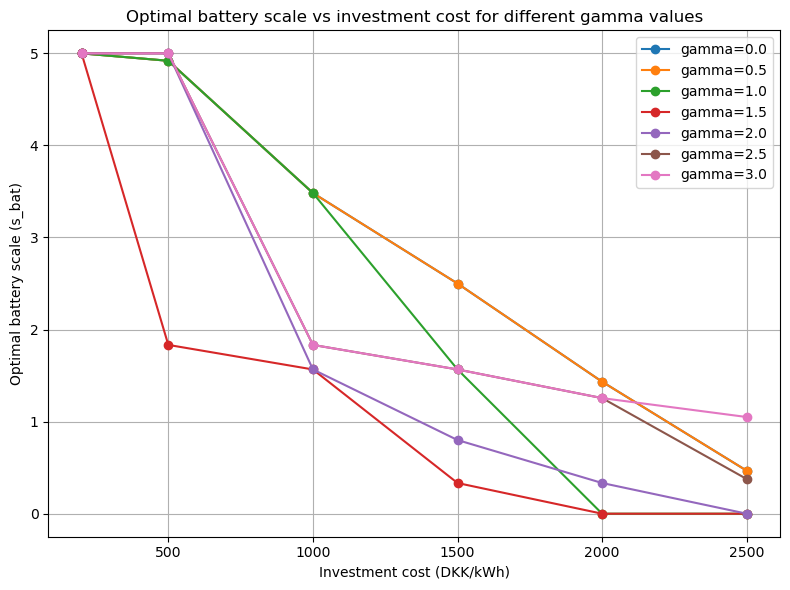

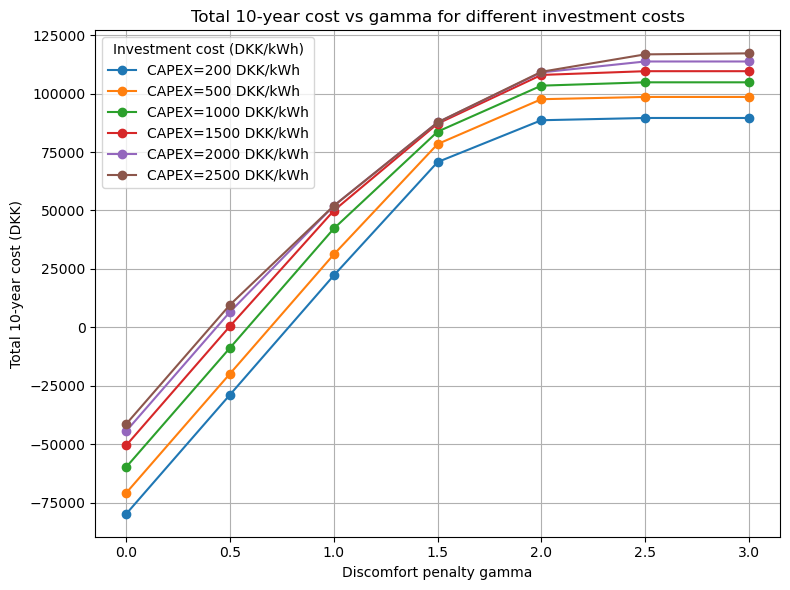

In [ ]:
# ---------- Flexibility preferences simulations ----------

def run_battery_investment_sim(gamma_value, investment_cost):
    """
    Solve the consumer optimization problem with battery investment as a variable,
    for a given gamma (discomfort penalty) and battery CAPEX (DKK/kWh)
    """
    m = gp.Model(f"gamma_{gamma_value}_capex_{investment_cost}")
    m.setParam('OutputFlag', 0)
    
    # Decision variable: battery scaling
    s_bat_var = m.addVar(lb=0.0, ub=s_bat_ub, name="s_bat")
    
    # Operational variables
    x_vars = m.addVars(T, lb=0.0, ub=load_max_kWh, name="x")
    u_vars = m.addVars(T, lb=0.0, name="u")
    I_vars = m.addVars(T, lb=0.0, name="I")
    E_vars = m.addVars(T, lb=0.0, name="E")
    d_vars = m.addVars(T, lb=0.0, name="d")
    
    # Battery variables
    p_ch_vars = m.addVars(T, lb=0.0, name="p_ch")
    p_dis_vars = m.addVars(T, lb=0.0, name="p_dis")
    SOC_vars = m.addVars(T, lb=0.0, name="SOC")
    
    # Constraints
    for t in T:
        m.addConstr(u_vars[t] <= pv_avail[t], name=f"pv_cap_{t}")
        m.addConstr(I_vars[t] <= max_import, name=f"import_cap_{t}")
        m.addConstr(E_vars[t] <= max_export, name=f"export_cap_{t}")
        m.addConstr(I_vars[t] - E_vars[t] + u_vars[t] + p_dis_vars[t] == x_vars[t] + p_ch_vars[t], name=f"balance_{t}")
        m.addConstr(d_vars[t] >= x_vars[t] - r[t], name=f"dev_pos_{t}")
        m.addConstr(d_vars[t] >= r[t] - x_vars[t], name=f"dev_neg_{t}")
        m.addConstr(p_ch_vars[t] <= s_bat_var * P_ch0, name=f"p_ch_cap_{t}")
        m.addConstr(p_dis_vars[t] <= s_bat_var * P_dis0, name=f"p_dis_cap_{t}")
        m.addConstr(SOC_vars[t] <= s_bat_var * C0, name=f"soc_max_{t}")
    
    # SOC dynamics
    m.addConstr(SOC_vars[0] == initial_soc_ratio * s_bat_var * C0 + eta_ch * p_ch_vars[0] - (1/eta_dis) * p_dis_vars[0], name="soc_0")
    for t in T[1:]:
        m.addConstr(SOC_vars[t] == SOC_vars[t-1] + eta_ch * p_ch_vars[t] - (1/eta_dis) * p_dis_vars[t], name=f"soc_{t}")
    m.addConstr(SOC_vars[T[-1]] >= final_soc_ratio * s_bat_var * C0, name="terminal_soc")
    
    # Objective: total lifetime cost + investment
    daily_oper_cost = gp.quicksum(
        (prices[t] + import_tariff) * I_vars[t] - (prices[t] - export_tariff) * E_vars[t] + gamma_value * d_vars[t] 
        for t in T
    )
    lifetime_oper_cost = L_years * N_rep * daily_oper_cost
    invest_cost = investment_cost * C0 * s_bat_var
    m.setObjective(lifetime_oper_cost + invest_cost, GRB.MINIMIZE)
    
    m.optimize()
    
    if m.Status == GRB.OPTIMAL:
        return {
            "gamma": gamma_value,
            "investment_cost_per_kWh": investment_cost,
            "s_bat_opt": s_bat_var.X,
            "battery_capacity_kWh": s_bat_var.X * C0,
            "total_cost": m.ObjVal,
            "lifetime_oper_cost": lifetime_oper_cost.getValue(),
            "investment_cost": invest_cost.getValue(),
        }
    else:
        return {
            "gamma": gamma_value,
            "investment_cost_per_kWh": investment_cost,
            "s_bat_opt": None,
            "battery_capacity_kWh": None,
            "total_cost": None,
            "lifetime_oper_cost": None,
            "investment_cost": None,
        }

# ---------- Run scenario sweeps ----------
gamma_vals = np.arange(0, 3.5, 0.5)
investment_cost_vals = [200, 500, 1000, 1500, 2000, 2500]  # DKK/kWh

results = []
for inv_cost in investment_cost_vals:
    for gamma in gamma_vals:
        res = run_battery_investment_sim(gamma, inv_cost)
        results.append(res)

df_results = pd.DataFrame(results)
print(df_results)

# ---------- Optional: Plot optimal battery size vs gamma ----------
plt.figure(figsize=(10,6))
sns.lineplot(
    data=df_results,
    x="gamma",
    y="s_bat_opt",
    hue="investment_cost_per_kWh",
    marker="o",
    palette="viridis"
)
plt.xlabel("Discomfort penalty gamma")
plt.ylabel("Optimal battery size (kWh)")
plt.title("Optimal battery size vs gamma for different investment costs")
plt.legend(title="Investment cost (DKK/kWh)", loc="upper right", bbox_to_anchor=(1, 0.8))
plt.grid(True)
plt.show()


# Add columns for plotting
df_results['status'] = df_results['s_bat_opt'].notna()  
df_results['scenario'] = df_results['gamma'].apply(lambda g: f"gamma={g:.1f}")
df_results['c_inv'] = df_results['investment_cost_per_kWh']
df_results['total_cost_10y_DKK'] = df_results['total_cost']

# ---------- Plot: s_bat_opt vs CAPEX for each gamma scenario ----------
plt.figure(figsize=(8,6))
for scenario_name in df_results['scenario'].unique():
    df_s = df_results[(df_results['scenario'] == scenario_name) & (df_results['status'])]
    if df_s.empty:
        continue
    plt.plot(df_s['c_inv'], df_s['s_bat_opt'], marker='o', label=scenario_name)
plt.xlabel("Investment cost (DKK/kWh)")
plt.ylabel("Optimal battery scale (s_bat)")
plt.title("Optimal battery scale vs investment cost for different gamma values")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ---------- Plot: 10-year total cost vs CAPEX ----------
plt.figure(figsize=(8,6))
for c_inv in sorted(df_results['investment_cost_per_kWh'].unique()):
    df_s = df_results[(df_results['investment_cost_per_kWh'] == c_inv) & (df_results['s_bat_opt'].notna())]
    if df_s.empty:
        continue
    plt.plot(df_s['gamma'], df_s['total_cost_10y_DKK'], marker='o', label=f"CAPEX={c_inv} DKK/kWh")
plt.xlabel("Discomfort penalty gamma")
plt.ylabel("Total 10-year cost (DKK)")
plt.title("Total 10-year cost vs gamma for different investment costs")
plt.grid(True)
plt.legend(title="Investment cost (DKK/kWh)")
plt.tight_layout()
plt.show()

